# 1-D CNN model for CAP classification 
- Authors - Shruti Murarka, Aditya Wadichar

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [3]:
loadpkl=True

## Dataset

In [4]:
from os import listdir
# csvs=[str(i)+' Balanced data/'+n for i,n in enumerate(listdir('Balanced Data'))]
csvs=['Balanced data/'+i for i in listdir('Balanced Data')]
csvs

['Balanced data/bal_all.csv',
 'Balanced data/bal_healthy.csv',
 'Balanced data/bal_healthy_F4C4.csv',
 'Balanced data/bal_ins.csv',
 'Balanced data/bal_narco.csv',
 'Balanced data/bal_nfle.csv',
 'Balanced data/bal_plm.csv',
 'Balanced data/bal_rbd.csv',
 'Balanced data/bal_sdb.csv']

In [5]:
import pickle
if loadpkl:
    print('Loading bal_categories.pkl')
    with open('bal_categories.pkl', 'rb') as f:
        x_bal,y_bal,csvs = pickle.load(f)
else:
    x_bal_list = []
    y_bal_list = []

    for n,i in enumerate([1, 3, 4, 5, 6, 7, 8]):
        bal_all = np.loadtxt(csvs[i], delimiter=',')
        
        x_bal = bal_all[:, 0:1024]
        y_bal = bal_all[:, 1024]
        
        y_bal = y_bal.reshape(-1, 1)
        y_bal[:] = n
        
        x_bal_list.append(x_bal)
        y_bal_list.append(y_bal)

    x_bal = np.concatenate(x_bal_list, axis=0)
    y_bal = np.concatenate(y_bal_list, axis=0)

    print('Saving to bal_categories.pkl')
    with open('bal_categories.pkl', 'wb') as f:
        pickle.dump([x_bal,y_bal,csvs], f)

# Print the shapes to verify
print(f"x_bal shape: {x_bal.shape}")
print(f"y_bal shape: {y_bal.shape}")

Loading bal_categories.pkl
x_bal shape: (168000, 1024)
y_bal shape: (168000, 1)


In [6]:
# x_train1, x_test1, y_train1, y_test1 = train_test_split(x_bal, y_bal, test_size = 0.2, shuffle = False)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_bal, y_bal, test_size = 0.2, shuffle = True,stratify=y_bal)

In [7]:
from keras.utils import to_categorical
num_classes = 7
y_train1 = to_categorical(y_train1)
y_test1 = to_categorical(y_test1)

2024-06-05 16:08:27.988036: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 16:08:28.034999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 16:08:28.698426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-06-05 16:08:29.374369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 16:08:29.437665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 16:08:29.437745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [9]:
import matplotlib.pyplot as plt
def plotaccloss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 6))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Paper

### Hyperparameter Optimization

In [10]:
from sklearn.model_selection import KFold
from keras.models import Sequential
import keras.layers as tfl
from keras.utils import to_categorical

param = 16
num_classes = 7  # Number of output classes

kfold = KFold(n_splits=5, shuffle=True, random_state=1) 
fold_no = 1
acc_per_fold1 = []
loss_per_fold1 = []

for train, test in kfold.split(x_train1, y_train1):
    model = Sequential()
    model.add(tfl.Conv1D(filters=32,
                         kernel_size=7,
                         strides=1,
                         padding='same',
                         input_shape=(1024, 1)))

    model.add(tfl.Conv1D(filters=8,
                         kernel_size=3,
                         strides=1,
                         padding='same', activation='relu'))
    model.add(tfl.MaxPool1D(pool_size=16,
                            padding='same'))
    model.add(tfl.Conv1D(filters=16,
                         kernel_size=2,
                         strides=1,
                         padding='same'))
    model.add(tfl.Dropout(0.4))
    model.add(tfl.Conv1D(filters=8,
                         kernel_size=2,
                         strides=1,
                         padding='same', activation='relu'))
    model.add(tfl.MaxPool1D(pool_size=4,
                            padding='same'))
    model.add(tfl.Flatten())
    model.add(tfl.Dense(param, activation='relu'))    ## parameter change
    model.add(tfl.Dense(num_classes, activation='softmax'))  # Changed activation and output size
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history1 = model.fit(x_train1[train], to_categorical(y_train1[train], num_classes=num_classes),
                         batch_size=75,
                         epochs=50)

    # Generate generalization metrics
    scores1 = model.evaluate(x_train1[test], to_categorical(y_train1[test], num_classes=num_classes), verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores1[0]}; {model.metrics_names[1]} of {scores1[1]*100}%')
    acc_per_fold1.append(scores1[1] * 100)
    loss_per_fold1.append(scores1[0])

    # Increase fold number
    fold_no += 1


/home/pece/patrones/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-05 15:08:06.444162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 15:08:06.444284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 15:08:06.444302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Y

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50


I0000 00:00:1717618091.181582  190018 service.cc:145] XLA service 0x7efdec00d4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717618091.181652  190018 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-05 15:08:11.261297: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-05 15:08:11.475132: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  27/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2571 - loss: 6.7256 

I0000 00:00:1717618094.479402  190018 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1434/1434 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4281 - loss: 1.8034
Epoch 2/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4949 - loss: 1.4194
Epoch 3/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5284 - loss: 1.3588
Epoch 4/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5337 - loss: 1.3369
Epoch 5/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5437 - loss: 1.3094
Epoch 6/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5479 - loss: 1.2971
Epoch 7/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5536 - loss: 1.2845
Epoch 8/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5544 - loss: 1.2802
Epoch 9/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5522 - loss: 1.2799
Epoch 10/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5542 - loss: 1.2750
Epoch 11/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5592 - loss: 1.2651
Epoch 12/50
1434/1434 ━━━━━━━━━━━━━━━━━━

: 

: 

: 

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold1)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold1[i]} - Accuracy: {acc_per_fold1[i]}%')  
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold1)} (+- {np.std(acc_per_fold1)})')
print(f'> Loss: {np.mean(loss_per_fold1)}')
print('------------------------------------------------------------------------')

#np.savetxt('/content/drive/MyDrive/FYP/Hyper_opti/dense_param4.csv', acc_per_fold1, delimiter=',')
# np.savetxt('Hyper_opti/dense_param4.csv', acc_per_fold1, delimiter=',')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6401397585868835 - Accuracy: 61.51653528213501%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6238344311714172 - Accuracy: 63.968074321746826%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6481197476387024 - Accuracy: 61.972635984420776%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.624061107635498 - Accuracy: 64.36716318130493%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6259326338768005 - Accuracy: 65.43068885803223%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 63.451019525527954 (+- 1.4801082871819498)
> Loss: 0.6324175357818603
--------------------------

In [ ]:
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_74 (Conv1D)              │ (None, 1024, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 1024, 8)        │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 64, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 64, 16)         │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 64, 8)          │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,949 (42.77 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,300 (28.52 KB)

In [10]:
from keras.models import Sequential
import keras.layers as tfl

param = 16
num_classes = 7  # Number of output classes

# Build the model
model = Sequential()
model.add(tfl.Conv1D(filters=32,
                     kernel_size=7,
                     strides=1,
                     padding='same',
                     input_shape=(1024, 1)))

model.add(tfl.Conv1D(filters=8,
                     kernel_size=3,
                     strides=1,
                     padding='same', activation='relu'))
model.add(tfl.MaxPool1D(pool_size=16,
                        padding='same'))
model.add(tfl.Conv1D(filters=16,
                     kernel_size=2,
                     strides=1,
                     padding='same'))
model.add(tfl.Dropout(0.4))
model.add(tfl.Conv1D(filters=8,
                     kernel_size=2,
                     strides=1,
                     padding='same', activation='relu'))
model.add(tfl.MaxPool1D(pool_size=4,
                        padding='same'))
model.add(tfl.Flatten())
model.add(tfl.Dense(param, activation='relu'))    # Parameter change
model.add(tfl.Dense(num_classes, activation='softmax'))  # Changed activation and output size
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/home/pece/patrones/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-05 16:08:29.569265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 16:08:29.569390: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 16:08:29.569422: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Y

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1024, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1024, 8)        │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 16)         │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 64, 8)          │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,751 (14.65 KB)

 Trainable params: 3,751 (14.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6187 - loss: 1.0529 - val_accuracy: 0.6201 - val_loss: 1.0342
Epoch 2/200
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6168 - loss: 1.0566 - val_accuracy: 0.6175 - val_loss: 1.0414
Epoch 3/200
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6181 - loss: 1.0556 - val_accuracy: 0.6148 - val_loss: 1.0458
Epoch 4/200
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6162 - loss: 1.0576 - val_accuracy: 0.6169 - val_loss: 1.0498
Epoch 5/200
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6173 - loss: 1.0553 - val_accuracy: 0.6146 - val_loss: 1.0451
Epoch 6/200
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6149 - loss: 1.0595 - val_accuracy: 0.6164 - val_loss: 1.0435
Epoch 7/200
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6180 - loss: 1.0517 - val_accuracy: 0.6154 - val_loss: 1.0693
Epoch 8/200
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6161 - loss: 1

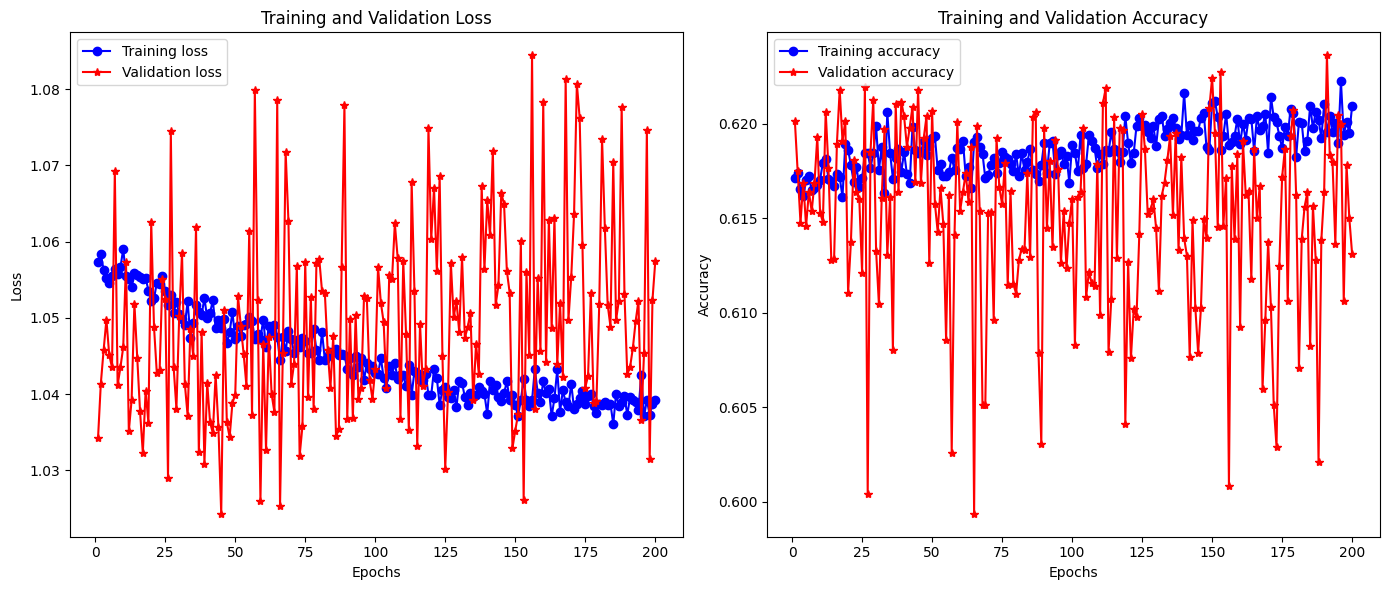

In [14]:
history = model.fit(x_train1, y_train1,batch_size=75,epochs=200, validation_split=0.2)

scores = model.evaluate(x_test1,y_test1, verbose=0)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

plotaccloss(history)